In [1]:
from functions_Chebyshev_basis_lag import g_D_symbolic_coefficients
from functions_Chebyshev_basis_lag import generate_lag
from functions_Chebyshev_basis_lag import restore_matrices
from functions_Chebyshev_basis_lag import Augmented_Lagrangian as new
from functions_Chebyshev_basis_lag import update_Lagrangian_coefficients
from functions_Chebyshev_basis_lag import generate_M_d
from functions_Chebyshev_basis_lag import generate_x_input
from functions_Chebyshev_basis_lag import compute_function
import numpy as np
from scipy.integrate import quad
from functools import partial
import jax
import jax.numpy as jaxnp
from scipy.optimize import minimize

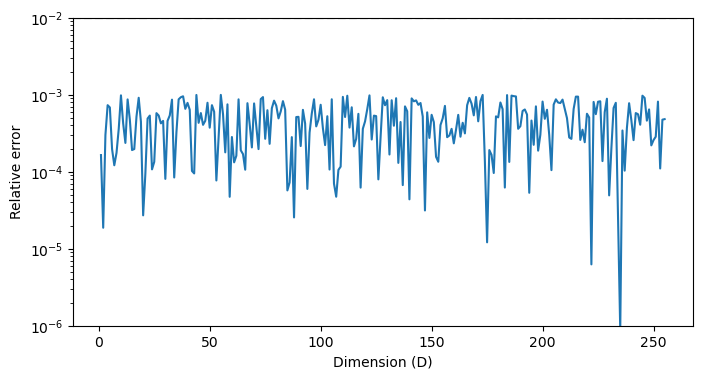

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace these with your actual data)
D_list = [i for i in range(1, 256)]  # Dimension list
Relative_Error = np.random.rand(255) * 1e-3  # Replace with your Relative Error values

# Create the plot
plt.figure(figsize=(8, 4))
plt.plot(D_list, Relative_Error, label="Relative Error")
plt.yscale('log')  # Setting the y-axis to a logarithmic scale
plt.axhline(y=1e-2, color='black', linestyle='--')  # Dashed line at y = 1e-2

# Add labels and title
plt.xlabel("Dimension (D)")
plt.ylabel("Relative error")
plt.ylim(1e-6, 1e-2)  # Limit y-axis to show the range from 1e-6 to 1e-2

# Show the plot
plt.show()


In [3]:
11/2

5.5

In [2]:
D = 10
d = 8
L = 12
rho = 10

In [3]:
rho = 20
orders_list, coefficients_list, polynomial_numeric, x = g_D_symbolic_coefficients(D)
x_input= generate_x_input(D,d,L)
Lagrangian_coefficient = generate_lag(D,d,L)
print(Lagrangian_coefficient[0])

Expanded Result:
-x1**8*x10**8*x2**8*x3**8*x4**8*x5**8*x6**8*x7**8*x8**8*x9**8 + 0.1*x1**2 + 0.1*x10**2 + 0.1*x2**2 + 0.1*x3**2 + 0.1*x4**2 + 0.1*x5**2 + 0.1*x6**2 + 0.1*x7**2 + 0.1*x8**2 + 0.1*x9**2

Coefficients Dictionary:
Coefficient of (8, 8, 8, 8, 8, 8, 8, 8, 8, 8): -1.0
Coefficient of (2, 0, 0, 0, 0, 0, 0, 0, 0, 0): 0.1
Coefficient of (0, 0, 0, 0, 0, 0, 0, 0, 0, 2): 0.1
Coefficient of (0, 2, 0, 0, 0, 0, 0, 0, 0, 0): 0.1
Coefficient of (0, 0, 2, 0, 0, 0, 0, 0, 0, 0): 0.1
Coefficient of (0, 0, 0, 2, 0, 0, 0, 0, 0, 0): 0.1
Coefficient of (0, 0, 0, 0, 2, 0, 0, 0, 0, 0): 0.1
Coefficient of (0, 0, 0, 0, 0, 2, 0, 0, 0, 0): 0.1
Coefficient of (0, 0, 0, 0, 0, 0, 2, 0, 0, 0): 0.1
Coefficient of (0, 0, 0, 0, 0, 0, 0, 2, 0, 0): 0.1
Coefficient of (0, 0, 0, 0, 0, 0, 0, 0, 2, 0): 0.1
[(8, 8, 8, 8, 8, 8, 8, 8, 8, 8), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0, 0, 0, 2), (0, 2, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 2, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 2, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, 2, 0, 

In [4]:
def Augmented_Lagrangian(x_input,d,D,L,orders_list,coefficients_list,Lagrangian_coefficient,rho):
    """
    x is the flattend x
    D is the number of variables in polynomial
    L is the number of measures
    orders_list is the list of different terms(e.g. x1^2*x2^2) in polynomials
    coefficients_list is the list of coefficients of the above terms
    Lagrangian_coefficient is Lagrangian coefficient
    rho is the penalty term 

    """
    #Before we start, we need to reshape the x input back to the original format, which is the matrix form

    x_mu_D_L_list,x_R_L_list = restore_matrices(s=x_input,d=d,D=D,L=L)
    
    sum_result = 0

    #First term
    sum_result += term_1(D,L,x_mu_D_L_list,orders_list,coefficients_list)

    #Here we need to generate the real M_d matrix from our list of moments of measure

    x_M_D_L_list = generate_M_d(x_mu_D_L_list,d,D,L)
    
    x_mu_D_L_list = jaxnp.array(x_mu_D_L_list).reshape((D*L,2*d+3))
    x_M_D_L_list = jaxnp.array(x_M_D_L_list).reshape((D*L,d+1,d+1))
    x_R_L_list = jaxnp.array(x_R_L_list).reshape((D*L,d+1,d+1))
    #Second term
    sum_result += term_2(D,L,x_M_D_L_list,x_mu_D_L_list,x_R_L_list,Lagrangian_coefficient)
    
    #Third term
    # sum_result += term_3(D,L,x_M_D_L_list,x_mu_D_L_list,x_R_L_list,rho)
    return sum_result

#This is the sum of the polynomials
def term_1(D,L,x_mu_D_L_list,orders_list,coefficients_list):
    sum = 0
    for i in range(len(orders_list)):
        moments_product_sum = 0
        for l in range(L):
            moments_prodect = 1
            for j in range(D):
                moments_prodect *= x_mu_D_L_list[j][l][orders_list[i][j]]
            moments_product_sum += moments_prodect
        sum +=coefficients_list[i]*moments_product_sum
    return sum

#Lagrangian term
def term_2(D,L,x_M_D_L_list,x_mu_D_L_list,x_R_L_list,Lagrangian_coefficient):
    
    sum = 0
    # Md(mu_0^(l)) - R_0^l R_0^l.T = 0
    lag_first = np.array(Lagrangian_coefficient[0]).reshape((D*L,d+1,d+1))
    def first(lag_first,x_M_D_L,x_R_L):
        return jaxnp.sum(lag_first*(x_M_D_L-jaxnp.dot(x_R_L,x_R_L.T)))

    batched_first = jax.vmap(first)
    sum+= jaxnp.sum(batched_first(lag_first,x_M_D_L_list,x_R_L_list))
    

    # mu_(1,0)^l>=0
    for l in range(L):
        sum += Lagrangian_coefficient[1][0][l]*max(-x_M_D_L_list[D*l][0,0],0)
    
    # mu_(i,0)^l - 1 = 0
    for i in range(D-1):
        for l in range(L):
            sum += Lagrangian_coefficient[1][i][l]*(x_M_D_L_list[D*l][0,0]-1)
    
    #8 B.2.1.
    lag_second = np.array(Lagrangian_coefficient[2]).reshape((D*L,2*d+3))
    def second(lag_second,x_mu_D_L):
        return jaxnp.sum(lag_second*(jaxnp.maximum(0,-x_mu_D_L-1)+jaxnp.maximum(0,x_mu_D_L-1)))

    batched_second = jax.vmap(second)
    sum+= jaxnp.sum(batched_second(lag_second,x_mu_D_L_list))

    
    return sum

#Penanlty term
def term_3(D,L,x_M_D_L_list,x_mu_D_L_list,x_R_L_list,rho):
    sum = 0 
    # Md(mu_0^(l)) - R_0^l R_0^l.T = 0
    for i in range(D):
        for l in range(L):
            sum += jaxnp.sum(jaxnp.square((x_M_D_L_list[i][l]-jaxnp.dot(x_R_L_list[i][l],x_R_L_list[i][l].T))))
       
    # mu_(1,0)^l>=0 
    # here we define the penalty term as max(0, -g)**2 since we need to let it >=0 
    for l in range(L):
        sum += max(0,-x_M_D_L_list[0][l][0,0])**2
    
    # mu_(i,0)^l - 1 = 0
    for i in range(D-1):
        for l in range(L):
            sum += (x_M_D_L_list[i+1][l][0,0]-1)**2
       
    # B.2.1.
    for i in range(D):
        for l in range(L):
                sum+= jaxnp.sum(jaxnp.square(jaxnp.maximum(0,-x_mu_D_L_list[i][l]-1)+jaxnp.maximum(0,x_mu_D_L_list[i][l]-1)))
    
    return rho/2*sum

In [5]:
x_mu_D_L_list,x_R_L_list = restore_matrices(s=x_input,d=d,D=D,L=L)
print(np.array(x_mu_D_L_list).reshape((D*L,2*d+3)))
print(np.array(x_mu_D_L_list).reshape((D*L,2*d+3)))

[[ 1.          0.         -0.33333334 ... -0.00392157  0.
  -0.00309598]
 [ 1.          0.         -0.33333334 ... -0.00392157  0.
  -0.00309598]
 [ 1.          0.         -0.33333334 ... -0.00392157  0.
  -0.00309598]
 ...
 [ 1.          0.         -0.33333334 ... -0.00392157  0.
  -0.00309598]
 [ 1.          0.         -0.33333334 ... -0.00392157  0.
  -0.00309598]
 [ 1.          0.         -0.33333334 ... -0.00392157  0.
  -0.00309598]]
[[ 1.          0.         -0.33333334 ... -0.00392157  0.
  -0.00309598]
 [ 1.          0.         -0.33333334 ... -0.00392157  0.
  -0.00309598]
 [ 1.          0.         -0.33333334 ... -0.00392157  0.
  -0.00309598]
 ...
 [ 1.          0.         -0.33333334 ... -0.00392157  0.
  -0.00309598]
 [ 1.          0.         -0.33333334 ... -0.00392157  0.
  -0.00309598]
 [ 1.          0.         -0.33333334 ... -0.00392157  0.
  -0.00309598]]


In [6]:
aug_lagrangian_partial = partial(Augmented_Lagrangian, d=d, D=D, L=L, orders_list=orders_list,
                                coefficients_list=coefficients_list,
                                Lagrangian_coefficient=Lagrangian_coefficient, rho=rho)
aug_lagrangian_partial_old = partial(new, d=d, D=D, L=L, orders_list=orders_list,
                                coefficients_list=coefficients_list,
                                Lagrangian_coefficient=Lagrangian_coefficient, rho=rho)
aug_lagrangian_partial_gradient = jax.grad(aug_lagrangian_partial)
aug_lagrangian_partial_gradient_old = jax.grad(aug_lagrangian_partial_old)

In [7]:
print(aug_lagrangian_partial(x_input))
print(aug_lagrangian_partial_old(x_input))

-3.999999
-3.999999


In [8]:
print(aug_lagrangian_partial_gradient(x_input))

[-0.3  0.   0.1 ...  0.   0.   0. ]


In [9]:
print(aug_lagrangian_partial_gradient_old(x_input))

[-0.3  0.   0.1 ...  0.   0.   0. ]
